In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import re 
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
# read dataset and save it into df variable
df = pd.read_json('../Datasets/Cell_Phones_and_Accessories_5.json', lines=True)

In [3]:
# rename columns for better understanding
df = df.rename(columns={"reviewText":"Review","overall": "Rating","summary":"Title"})

# drop unessesary data
df.drop(['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis='columns', inplace=True)

# split the helpful tuple into two new rows
df['helpful_0'] = df['helpful'].apply(func=lambda x: x[0])
df['helpful_1'] = df['helpful'].apply(func=lambda x: x[1])

# Remove Reviews that have less than 2 helpful votes
df = df[df['helpful_1'] >= 2]

# add calculation of helpfullness ration and convert it to an int percentage
df['helpful_ratio'] = df['helpful_0'] / df['helpful_1']
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)

# calculate length of reviews in new column
df['review_len'] = [len(text.split()) for text in df.Review]

In [4]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [5]:
df['IsHelpful'] = df.apply(convert_label, axis = 1)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.000000,100,51,1
4,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,0.666667,66,23,0
5,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1,2,0.500000,50,23,0
7,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1,2,0.500000,50,20,0
8,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,0.666667,66,44,0


In [16]:
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

df['cleaned_reviews'] = df['Review'].apply(DataPrep)
print(f'There are around {int(df["cleaned_reviews"].duplicated().sum())} duplicated reviews, we will remove them.')
df.drop_duplicates("cleaned_reviews", inplace=True)

There are around 90 duplicated reviews, we will remove them.


In [7]:
## achtung dauert so 10 Min
# calculate number of adjectives per review
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

def count_adjectives(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stopwords.words('english')]
    pos_tags = pos_tag(words)
    adjectives = [word for word, tag in pos_tags if tag.startswith('JJ')]
    return len(adjectives)

df['Adjective_Count'] = df['Review'].apply(count_adjectives)
df['Adjective_Ratio'] = df['Adjective_Count'] / df['review_len']

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laurareimann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurareimann/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurareimann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# calculate the adjective percentage
df['Adjective_Ratio'] = df['Adjective_Ratio'].fillna(0)  # Replace NaN with 0 or any other suitable default value
df['adjective_percent'] = (df['Adjective_Ratio'] * 100).astype(int)

df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,Adjective_Count,Adjective_Ratio,adjective_percent
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.000000,100,51,1,5,0.098039,9
4,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,0.666667,66,23,0,3,0.130435,13
5,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1,2,0.500000,50,23,0,2,0.086957,8
7,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1,2,0.500000,50,20,0,1,0.050000,5
8,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,0.666667,66,44,0,5,0.113636,11


In [ ]:
# was macht das nochmal?
label_count = df['IsHelpful'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

#sns.countplot(df['Rating'] , ax=axes[1])
counts = df['IsHelpful'].value_counts().sort_index()
counts.plot.bar(color=color)
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
# split data
x_train, x_val, y_train, y_val, len_train, len_val, adj_train, adj_val = train_test_split(df['cleaned_reviews'], df['IsHelpful'], df['review_len'], df['adjective_percent'], train_size=0.80, random_state=42)
len(x_train), len(x_val)

(22428, 5608)

In [18]:
# Feature Extraction
vec = TfidfVectorizer()
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names_out()))

No. of feature words:  78975


In [19]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

# Add 'len' & 'adj' feature to the TF-IDF transformed data
x_train_combined = np.column_stack((x_train, len_train, adj_train))
x_val_combined = np.column_stack((x_val, len_val, adj_val))

x_train.shape , x_val.shape

((22428, 78975), (5608, 78975))

In [20]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [21]:
train_acc1 = lr.score(x_train , y_train)

lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred) 

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 74.91%

The validation accuracy for logistic regression : 62.39%

The precision for logistic regression : 0.62

The recall for logistic regression : 0.62

The f1 score for logistic regression : 0.61



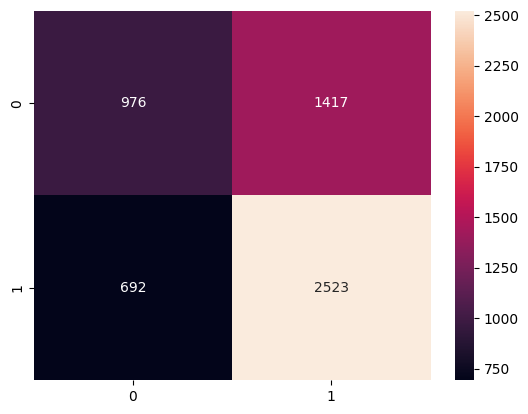

In [22]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

In [23]:
# Model mit adjective ratio
lr1 = LogisticRegression(random_state=42)
lr1.fit(x_train_combined, y_train)

LogisticRegression(random_state=42)

In [24]:
train_acc1_2 = lr1.score(x_train_combined , y_train)

lr1_pred = lr1.predict(x_val_combined)

val_acc1_2 = accuracy_score(y_val , lr1_pred) 

val_precision1_2 = precision_score(y_val , lr1_pred , average='weighted')
val_recall1_2 = recall_score(y_val , lr1_pred , average='weighted')
val_f1score1_2 = f1_score(y_val , lr1_pred , average='weighted')

print(f"The training accuracy for logistic regression : {(train_acc1_2*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1_2*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1_2:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1_2:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1_2:0.2f}\n")

The training accuracy for logistic regression : 68.55%

The validation accuracy for logistic regression : 62.21%

The precision for logistic regression : 0.61

The recall for logistic regression : 0.62

The f1 score for logistic regression : 0.61



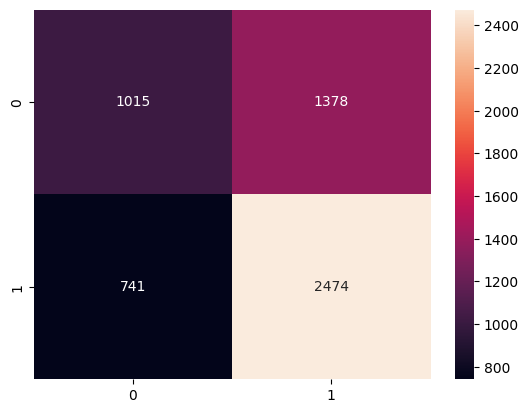

In [25]:
lr1_cm = confusion_matrix(y_val , lr1_pred)
sns.heatmap(lr1_cm, annot=True,fmt='3g')
plt.show()

In [32]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

RandomForestClassifier()

In [33]:
train_acc2 = rf.score(x_train , y_train)

rf_pred = rf.predict(x_val)

val_acc2 = accuracy_score(y_val , lr_pred) 

val_precision2 = precision_score(y_val , rf_pred , average='weighted')
val_recall2 = recall_score(y_val , rf_pred , average='weighted')
val_f1score2 = f1_score(y_val , rf_pred , average='weighted')

print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The validation accuracy for Random Forest : {(val_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {val_precision2:0.2f}\n")
print(f"The recall for Random Forest : {val_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {val_f1score2:0.2f}\n")

The training accuracy for Random Forest : 100.00%

The validation accuracy for Random Forest : 62.39%

The precision for Random Forest : 0.61

The recall for Random Forest : 0.61

The f1 score for Random Forest : 0.58



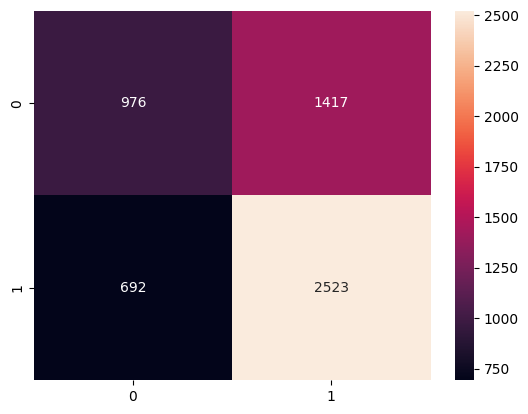

In [34]:
rf_cm = confusion_matrix(y_val , rf_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

In [35]:
# Random Forest mit adj ratio
rf = RandomForestClassifier()
rf.fit(x_train_combined , y_train)

RandomForestClassifier()

In [36]:
train_acc1_2 = lr1.score(x_train_combined , y_train)

lr1_pred = lr1.predict(x_val_combined)

val_acc1_2 = accuracy_score(y_val , lr1_pred) 

val_precision1_2 = precision_score(y_val , lr1_pred , average='weighted')
val_recall1_2 = recall_score(y_val , lr1_pred , average='weighted')
val_f1score1_2 = f1_score(y_val , lr1_pred , average='weighted')

print(f"The training accuracy for logistic regression : {(train_acc1_2*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1_2*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1_2:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1_2:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1_2:0.2f}\n")

The training accuracy for logistic regression : 68.55%

The validation accuracy for logistic regression : 62.21%

The precision for logistic regression : 0.61

The recall for logistic regression : 0.62

The f1 score for logistic regression : 0.61



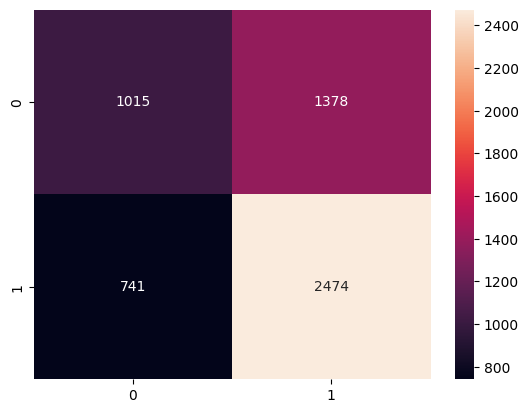

In [37]:
lr1_cm = confusion_matrix(y_val , lr1_pred)
sns.heatmap(lr1_cm, annot=True,fmt='3g')
plt.show()